In [1]:
#!/usr/bin/env python
# coding: utf-8

# # 2D Advection-Diffusion equation

# in this notebook we provide a simple example of the DeepMoD algorithm and apply it on the 2D advection-diffusion equation.

The supplementary material of the paper states that the data in advection-diffusion problem was generated from a PDE:

$$\frac{\partial u}{\partial t} = -0.25 \frac{\partial u}{\partial x} -0.5 \frac{\partial u}{\partial y} + 0.5\frac{\partial^2 u}{\partial x^2} + 0.5\frac{\partial^2 u}{\partial y^2} $$

However, there could be a typo in the supplamentary material because if we look at the expression identified in the tensorflow and pytorch repos it actually does not have a minus sign

In [1]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt

# DeepMoD functions

from deepymod import DeepMoD
from deepymod.data import Dataset, get_train_test_loader
from deepymod.data.samples import Subsample_random
from deepymod.model.func_approx import NN
from deepymod.model.library import Library2D
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Threshold, PDEFIND
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic
from scipy.io import loadmat

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)

# Configuring GPU or CPU
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cuda


# Preview the data
Before we dataset is put into a dataset and load it into the DeePyMoD framework, we can preview the data to get a feeling for the shape.

In [2]:
data = loadmat("data/advection_diffusion.mat")
usol = np.real(data["Expression1"]).astype("float32")
usol = usol.reshape((51, 51, 61, 4))
x_v= usol[:,:,:,0]
y_v = usol[:,:,:,1]
t_v = usol[:,:,:,2]
u_v = usol[:,:,:,3]

In [3]:
x_v.shape, y_v.shape, t_v.shape, u_v.shape

((51, 51, 61), (51, 51, 61), (51, 51, 61), (51, 51, 61))

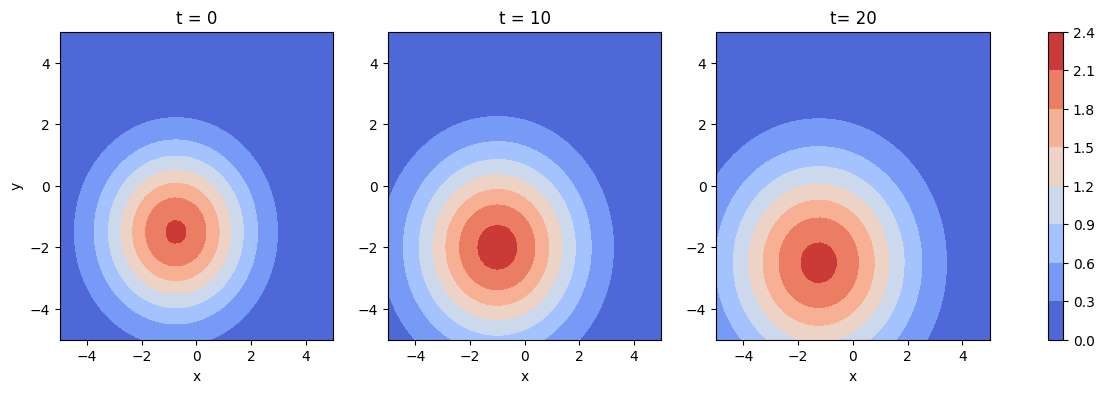

In [4]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

im0 = axes[0].contourf(x_v[:,:,0], y_v[:,:,0], u_v[:,:,0], cmap='coolwarm')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('t = 0')

im1 = axes[1].contourf(x_v[:,:,10], y_v[:,:,10], u_v[:,:,10], cmap='coolwarm')
axes[1].set_xlabel('x')
axes[1].set_title('t = 10')

im2 = axes[2].contourf(x_v[:,:,20], y_v[:,:,20], u_v[:,:,20], cmap='coolwarm')
axes[2].set_xlabel('x')
axes[2].set_title('t= 20')

fig.colorbar(im1, ax=axes.ravel().tolist())

plt.show()

## Prepare the data

Next, we actually prepare the dataset. In order to do so, we write a 
function that loads the data from the matlab file and then reshapes it into a shape with the
number of samples on the first axis and the coordinates on the next. 
We do so identically for the data then return both in a (time, x, y, data) format. We could also flatten the data and return it as (number_of_samples, number_of_features).

In [5]:
def create_data():
    data = loadmat("data/advection_diffusion.mat")
    usol = np.real(data["Expression1"]).astype("float32")
    usol = usol.reshape((51, 51, 61, 4))
    x_v = usol[:,:,:,0]
    y_v = usol[:,:,:,1]
    t_v = usol[:,:,:,2]
    u_v = usol[:,:,:,3]
    coords = torch.from_numpy(np.stack((t_v,x_v, y_v), axis=-1))
    data = torch.from_numpy(usol[:, :, :, 3]).unsqueeze(-1)
    # alternative way of providing the coordinates
    # coords = torch.from_numpy(np.transpose((t_v.flatten(), x_v.flatten(), y_v.flatten())))
    # data = torch.from_numpy(usol[:, :, :, 3].reshape(-1,1))
    print("The coodinates have shape {}".format(coords.shape))
    print("The data has shape {}".format(data.shape))
    return coords, data

Then we pass this function to the dataset class, which then adds noise to it, normalizes the coordinates and performs random subsampling to it.

In [6]:
dataset = Dataset(
    create_data,
    preprocess_kwargs={
        "noise_level": 0.01,
        "normalize_coords": True,
        "normalize_data": True,
    },
    subsampler=Subsample_random,
    subsampler_kwargs={"number_of_samples": 2500},
    device=device,
)

The coodinates have shape torch.Size([51, 51, 61, 3])
The data has shape torch.Size([51, 51, 61, 1])
Preprocessing data
Dataset is using device:  cuda


In [7]:
dataset.data.shape

torch.Size([2500, 1])

Next we use the get_train_test_loader function to get turn the dataset into PyTorch compatible dataloaders

In [9]:
train_dataloader, test_dataloader = get_train_test_loader(dataset, train_test_split=0.8)

In [10]:
for batch_idx, (input, target) in enumerate(train_dataloader):
    print(f"Batch {batch_idx} - Input shape: {input.shape}, Target shape: {target.shape}")


Batch 0 - Input shape: torch.Size([2000, 3]), Target shape: torch.Size([2000, 1])


## Configuration of DeepMoD

Configuration of the function approximator: Here the first argument is the number of input and the last argument the number of output layers.


In [11]:
network = NN(3, [50, 50, 50, 50], 1)

Configuration of the library function: We select athe library with a 2D spatial input. Note that that the max differential order has been pre-determined here out of convinience. So, for poly_order 1 the library contains the following 12 terms:
* [$1, u_x, u_y, u_{xx}, u_{yy}, u_{xy}, u, u u_x, u u_y, u u_{xx}, u u_{yy}, u u_{xy}$]

In [12]:
library = Library2D(poly_order=1)

Configuration of the sparsity estimator and sparsity scheduler used. In this case we use the most basic threshold-based Lasso estimator and a scheduler that asseses the validation loss after a given patience. If that value is smaller than 1e-5, the algorithm is converged.

In [13]:
estimator = Threshold(0.1)
sparsity_scheduler = TrainTestPeriodic()

Configuration of the sparsity estimator

In [14]:
constraint = LeastSquares()

Now we instantiate the model and select the optimizer

In [15]:
model = DeepMoD(network, library, estimator, constraint).to(device)

In [16]:
# Defining optimizer
optimizer = torch.optim.Adam(
    model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3
)

## Run DeepMoD

We can now run DeepMoD using all the options we have set and the training data:
* The directory where the tensorboard file is written (log_dir)
* The ratio of train/test set used (split)
* The maximum number of iterations performed (max_iterations)
* The absolute change in L1 norm considered converged (delta)
* The amount of epochs over which the absolute change in L1 norm is calculated (patience)

In [17]:
%%time
train(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    sparsity_scheduler,
    log_dir="runs/2DAD/",
    max_iterations=100000,
    delta = 1e-5,
    patience=200,
)

 34550  MSE: 2.57e-05  Reg: 3.38e-05  L1: 1.86e+00 Algorithm converged. Writing model to disk.
CPU times: user 14min 2s, sys: 19.3 s, total: 14min 21s
Wall time: 14min 4s


Legend:  [$1, u_x, u_y, u_{xx}, u_{yy}, u_{xy}, u, u u_x, u u_y, u u_{xx}, u u_{yy}, u u_{xy}$]

In [18]:
model.constraint_coeffs()

[tensor([[0.0000],
         [0.1498],
         [0.3019],
         [0.0588],
         [0.0581],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000]], device='cuda:0', grad_fn=<MaskedScatterBackward0>)]

In [19]:
model.sparsity_masks

[tensor([False,  True,  True,  True,  True, False, False, False, False, False,
         False, False], device='cuda:0')]

In [20]:
model.estimator_coeffs()

[array([[0.        ],
        [0.35692576],
        [0.72313076],
        [0.39699104],
        [0.3792838 ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]], dtype=float32)]